# Handwritten Digit Recognition with Softmax Function on TensorFlow

We'll be using a subset of the MNIST dataset, that is, 1000 28x28-pixel images of handwritten digits (100 images of the digit 0, 100 images of the digit 1, and so on up to the digit 9). We'll use a fairly simple model of a Feedforward Neural Network, implementing the Softmax activation function on the units of the output layer and ReLU on the hidden layer(s).

In this notebook, we will specifically utilize TensorFlow library to help building, compiling, and fitting the model into the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
np.set_printoptions(precision=2)

In [2]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
X_train = np.loadtxt('train_X.csv', delimiter = ',')
Y_train = np.loadtxt('train_label.csv', delimiter = ',')

X_test = np.loadtxt('test_X.csv', delimiter = ',')
Y_test = np.loadtxt('test_label.csv', delimiter = ',')

The shape of the feature and target matrices best remain in (m, n).

In [4]:
print("shape of X_train :", X_train.shape)
print("shape of Y_train :", Y_train.shape)
print("shape of X_test :", X_test.shape)
print("shape of Y_test :", Y_test.shape)

shape of X_train : (1000, 784)
shape of Y_train : (1000, 10)
shape of X_test : (350, 784)
shape of Y_test : (350, 10)


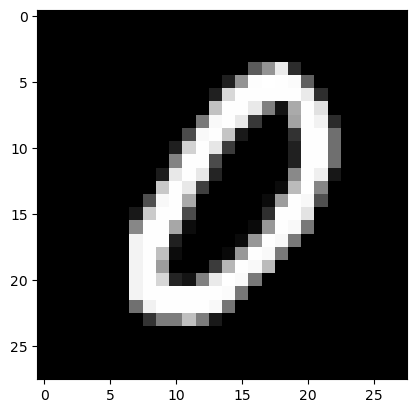

In [5]:
index = random.randrange(0, X_train.shape[0]) # Anywhere between 0 and the shape of first row (1000)
plt.imshow(X_train[index].reshape(28, 28), cmap='gray')
plt.show()

# Creating the Model

We use the Keras Dense layer to construct the FFNN architecture of two layers. Note the activation function used in each layer.

In [35]:
tf.random.set_seed(1234)  # applied to achieve consistent results
                          # we’ll get the same initial weights every time the code is run, 
                          # leading to the same model behavior and performance2.
model = Sequential(
    [
        tf.keras.Input(shape=(784,)),
        Dense(112, activation = 'relu',   name = "L1"),
        Dense(10, activation = 'linear', name = "L2")
    ], name = "mnist-softmax"
)

In [36]:
model.summary()

# Hidden layer (L1) : 784 * 32 individual weights + 32 biases (1 per unit) = 25120
# Output layer (L2) : 32 * 10 individual weights + 10 biases (1 per unit) = 330

Model: "mnist-softmax"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 112)               87920     
                                                                 
 L2 (Dense)                  (None, 10)                1130      
                                                                 
Total params: 89,050
Trainable params: 89,050
Non-trainable params: 0
_________________________________________________________________


Below is how the weights and biases look like before fitting.

In [37]:
# Keep in mind that W1 is the matrix of all weights in layer 1 (784, 32)
# And that W2 is the matrix of all weights in layer 2 (32, 10)

W1, b1 = model.get_layer("L1").get_weights()
W2, b2 = model.get_layer("L2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(784, 112):
 [[ 0.06  0.02 -0.06 ...  0.05 -0.03  0.07]
 [ 0.01  0.04  0.02 ...  0.07 -0.02 -0.  ]
 [-0.03  0.05 -0.   ...  0.06  0.02 -0.01]
 ...
 [ 0.08  0.03  0.07 ... -0.04 -0.04  0.04]
 [ 0.04 -0.08 -0.08 ...  0.06  0.04 -0.  ]
 [ 0.01 -0.03  0.07 ...  0.03 -0.01 -0.02]] 
b1(112,): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
W2(112, 10):
 [[-0.21  0.   -0.03 ...  0.05  0.21  0.21]
 [-0.08 -0.12 -0.   ... -0.17  0.09 -0.12]
 [-0.06 -0.01 -0.19 ...  0.2  -0.09  0.17]
 ...
 [-0.19 -0.13 -0.21 ...  0.18  0.07 -0.04]
 [ 0.15  0.14  0.07 ...  0.08 -0.11  0.09]
 [ 0.03  0.06  0.11 ... -0.08 -0.11 -0.12]] 
b2(10,): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Intuitively, we can map the value of each weight array of 784 elements in W1 as a 28x28 pixel image, similar to the shape of each training example.

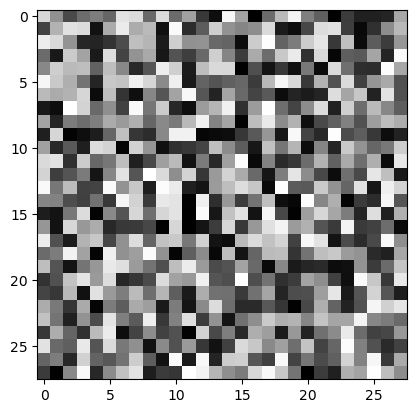

In [38]:
w1_image = W1[:, 0].reshape(28, 28)
plt.imshow(w1_image, cmap='gray')
plt.show()

As expected, it's just a jumble of ... whatever that might be, since no fitting has yet to be done on the dataset.

# Training and Fitting the Model

The statements below compile and train the network. Setting `from_logits=True` as an argument to the loss function specifies that the output activation was linear rather than a softmax.

In [39]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(0.01),
)

In [40]:
model.fit(
    X_train, Y_train,
    epochs = 10
)

Epoch 1/10
32/32 [==============================] - 1s 3ms/step - loss: 119.3048
Epoch 2/10
32/32 [==============================] - 0s 10ms/step - loss: 3.2164
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 1.3473
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 1.1072
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.9451
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.8295
Epoch 7/10
32/32 [==============================] - 0s 6ms/step - loss: 0.8170
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.8289
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.7442
Epoch 10/10
32/32 [==============================] - 0s 7ms/step - loss: 0.8822


After fitting the model into the respective inputs and targets of the dataset, we can see how the weights and biases turned out to be.

In [41]:
W1, b1 = model.get_layer("L1").get_weights()
W2, b2 = model.get_layer("L2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(784, 112):
 [[ 0.06  0.02 -0.06 ...  0.05 -0.03  0.07]
 [ 0.01  0.04  0.02 ...  0.07 -0.02 -0.  ]
 [-0.03  0.05 -0.   ...  0.06  0.02 -0.01]
 ...
 [ 0.08  0.03  0.07 ... -0.04 -0.04  0.04]
 [ 0.04 -0.08 -0.08 ...  0.06  0.04 -0.  ]
 [ 0.01 -0.03  0.07 ...  0.03 -0.01 -0.02]] 
b1(112,): [-0.03 -0.06 -0.06 -0.05 -0.01 -0.06 -0.03 -0.02 -0.04 -0.06 -0.05 -0.06
 -0.04 -0.04 -0.06 -0.06 -0.05 -0.06 -0.04 -0.06 -0.01 -0.06 -0.06 -0.06
 -0.06 -0.06 -0.06 -0.05 -0.02 -0.03 -0.07 -0.05 -0.04 -0.02 -0.06 -0.06
 -0.06 -0.04 -0.05 -0.06 -0.06 -0.08 -0.09 -0.06 -0.01 -0.06 -0.06 -0.06
 -0.05 -0.06 -0.04 -0.05 -0.11 -0.06 -0.04 -0.01 -0.04 -0.04 -0.05 -0.05
 -0.   -0.   -0.06 -0.07 -0.04 -0.07 -0.03 -0.06 -0.05 -0.06 -0.05 -0.06
 -0.12 -0.06 -0.03 -0.05 -0.01 -0.06 -0.06 -0.03 -0.03 -0.06 -0.06 -0.04
 -0.06 -0.04 -0.06 -0.06 -0.03 -0.04 -0.04 -0.06 -0.13 -0.06 -0.04 -0.06
  0.02 -0.06 -0.05 -0.06 -0.05 -0.03 -0.04 -0.06 -0.08 -0.06 -0.01 -0.03
 -0.01 -0.05 -0.06 -0.05]
W2(112, 10):
 [[-0.22  0.1 

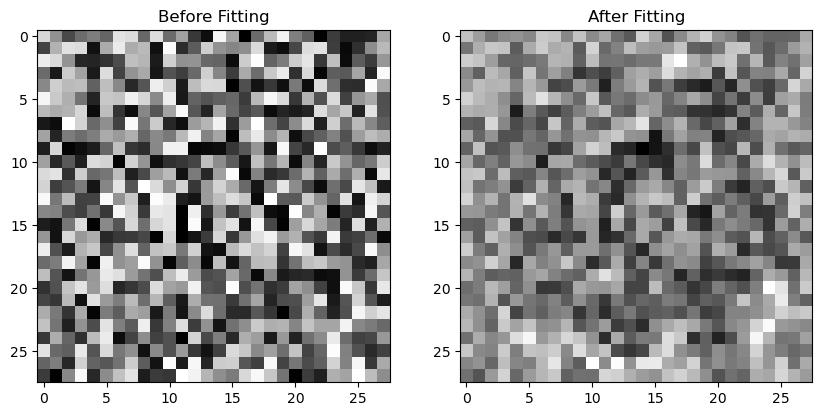

In [58]:
w1_image_fit = W1[:, 0].reshape(28, 28)
plt.figure(figsize=(10, 5))  # Set the figure size

plt.subplot(1, 2, 1)  # 1 row, 2 columns, index 1
plt.imshow(w1_image, cmap='gray')
plt.title('Before Fitting')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, index 2
plt.imshow(w1_image_fit, cmap='gray')
plt.title('After Fitting')

plt.show()

We can then predict on the X_test dataset. we first need to apply the Softmax activation function since the output layer uses a linear function. and thus does not represent the probability of each class.

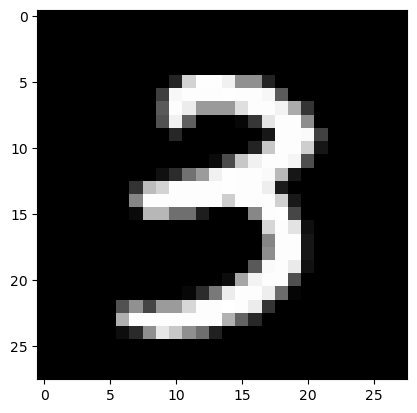

1/1 [==============================] - 0s 54ms/step
 Model probabilities: [[0.00e+00 8.67e-34 0.00e+00 1.00e+00 1.61e-37 5.69e-34 1.29e-43 1.54e-40
  5.26e-20 0.00e+00]]
 Model prediction: 3
 Actual target value: 3


In [59]:
idx = int(random.randrange(0,X_test.shape[0]))
plt.imshow(X_test[idx].reshape(28,28), cmap='gray')
plt.show()

label = np.argmax(Y_test[idx])


# Apply Softmax function
logits = model.predict(X_test[idx].reshape(1,784)) # TensorFlow only recognizes the shape of a tensor
# probabilities = np.exp(logits) / np.sum(np.exp(logits))

# We need to prevent numerical instability by ensuring that each logit has the value of 0 or negative
max_logit = np.max(logits)
shifted_logits = logits - max_logit
probabilities = np.exp(shifted_logits) / np.sum(np.exp(shifted_logits))

prediction = np.argmax(probabilities[0])

print(f" Model probabilities: {probabilities}")
print(f" Model prediction: {prediction}")
print(f" Actual target value: {label}")